## Planet four image classification

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
import sklearn.metrics as metrics
import tqdm

from torch.utils.data import DataLoader
from torchvision.datasets.folder import pil_loader
from pathlib import Path
from PIL import Image

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Change the device to "cpu" if you want to train on a CPU instead of a GPU.

In [3]:
device = 'cuda'

In [4]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sun Dec  4 11:59:46 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   59C    P0    29W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


## Dataset

Here we define a custom Dataset object for the Planet Four data. You can read more about this in the PyTorch documentation: https://pytorch.org/tutorials/beginner/basics/data_tutorial.html

In [14]:
class PlanetFourDataset(object):
    def __init__(self, split='train', transform=None, loader=pil_loader):
        super().__init__()
        self.split = split
        self.base_dir = Path('/content/drive/MyDrive/Planetfour/planetfour')
        self.image_dir = self.base_dir / split
        self.labels_file = self.base_dir / (split + '.csv')
        self.labels_df = pd.read_csv(self.labels_file)
        self.transform = transform
        self.loader = loader
        
    def __getitem__(self, index):
        row = self.labels_df.iloc[index]
        filename = self.image_dir / (row.tile_id + '.jpg')
        #print(filename)
        fans = int(row.fans)
        blotches = int(row.blotches)
        image = self.loader(str(filename))
        if self.transform is not None:
            image = self.transform(image)
        return image, torch.tensor([fans, blotches], dtype=torch.float32)
    
    def __len__(self):
        return len(self.labels_df)

## Data augmentation

It is standard practice in deep learning to augment the training examples to prevent the network from overfitting. Here I use some standard augmentations such as randomly mirroring the images.

In [7]:
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))                  
])

valid_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)) 
])

## Data loaders

In PyTorch, the data loaders take care of spinning up threads to load batches of data into memory from the dataset object.

In [8]:
train_set = PlanetFourDataset('train', transform=train_transform)
valid_set = PlanetFourDataset('valid', transform=train_transform)

train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
valid_loader = DataLoader(valid_set, batch_size=64, shuffle=False)

## Load a pretrained model

Here we'll use ResNet50 model that has been pretrained on ImageNet and replace the final layer with a new one suited to our problem.

In [9]:
model = models.resnet50(pretrained=True)
model.fc = nn.Linear(2048, 2)
model.to(device);

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

## Loss

Images can contain fans, blotches, both, or neither. You could treat this as a four class softmax problem, or two binary classification problems. Here I take the latter approach and use a binary cross entropy loss. 

In [10]:
criterion = nn.BCEWithLogitsLoss()

## Optimizer

Stochastic gradient descent with momentum

In [11]:
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-4)

## Training and validation functions

In [12]:
avg_train_losses = []
avg_valid_losses = []
valid_accuracies = []

trainloss_list = []
validloss_list = []

def make_list(x,y):
    trainloss_list.append(x)
    validloss_list.append(y)

def train_for_epoch(optimizer):
    model.train()

    train_losses = []

    for batch, target in tqdm.tqdm(train_loader):

        # data to GPU
        batch = batch.to(device)
        target = target.to(device)

        # reset optimizer
        optimizer.zero_grad()

        # forward pass
        predictions = model(batch)
        #breakpoint()

        # calculate loss
        loss = criterion(predictions, target)

        # backward pass
        loss.backward()

        # parameter update
        optimizer.step()

        # track loss
        train_losses.append(float(loss.item()))

    train_losses = np.array(train_losses)
    return train_losses


def validate():
    model.eval()

    valid_losses = []
    y_true, y_prob = [], []

    with torch.no_grad():
        for batch, target in valid_loader:

            # move data to the device
            batch = batch.to(device)
            target = target.to(device)

            # make predictions
            predictions = model(batch)

            # calculate loss
            loss = criterion(predictions, target)
            
            # logits -> probabilities
            torch.sigmoid_(predictions)

            # track losses and predictions
            valid_losses.append(float(loss.item()))
            y_true.extend(target.cpu().numpy())
            y_prob.extend(predictions.cpu().numpy())
            
    y_true = np.array(y_true)
    y_prob = np.array(y_prob)
    y_pred = y_prob > 0.5
    valid_losses = np.array(valid_losses)

    # calculate validation accuracy from y_true and y_pred
    fan_accuracy = metrics.accuracy_score(y_true[:,0], y_pred[:,0])
    blotch_accuracy = metrics.accuracy_score(y_true[:,1], y_pred[:,1])
    exact_accuracy = np.all(y_true == y_pred, axis=1).mean()

    # calculate the mean validation loss
    valid_loss = valid_losses.mean()

    return valid_loss, fan_accuracy, blotch_accuracy, exact_accuracy


def train(epochs, first_epoch=1):
    for epoch in range(first_epoch, epochs+first_epoch):

        # train
        train_loss = train_for_epoch(optimizer)

        # validation
        valid_loss, fan_accuracy, blotch_accuracy, both_accuracy = validate()
        print(f'[{epoch:02d}] train loss: {train_loss.mean():0.04f}  '
              f'valid loss: {valid_loss:0.04f}  ',
              f'fan acc: {fan_accuracy:0.04f}  ',
              f'blotch acc: {blotch_accuracy:0.04f}  ',
              f'both acc: {both_accuracy:0.04f}'
        )
        
        make_list(train_loss.mean(),valid_loss)
       
        
        # update learning curves
        avg_train_losses.append(train_loss.mean())
        avg_valid_losses.append(valid_loss)
        valid_accuracies.append((fan_accuracy, blotch_accuracy, both_accuracy))

print('trainloss_list = ', trainloss_list)
print('validloss_list = ', validloss_list)
        
        # save checkpoint
        #torch.save(model, f'checkpoints/baseline_{epoch:03d}.pkl')

trainloss_list =  []
validloss_list =  []


## Constant classifier accuracy

Evaluate how accurate would a $f(x) = \text{"most common class"}$ classifier be? 

In [ ]:
def constant_clf_accuracy():
    y_true, y_pred = [], []
    with torch.no_grad():
        for _, target in valid_loader:
            y_true.extend(target.cpu().numpy())
            y_pred.extend(np.ones((target.shape[0], 2), dtype=np.float32))
            
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
        
    # calculate validation accuracy from y_true and y_pred
    f = metrics.accuracy_score(y_true[:,0], y_pred[:,0])
    b = metrics.accuracy_score(y_true[:,1], y_pred[:,1])
    t = np.all(y_true == y_pred, axis=1).mean()
    print(f'fan: {f}  blotch: {b}  both: {t}')

In [ ]:
constant_clf_accuracy()

fan: 0.6218644702358667  blotch: 0.8083114938225384  both: 0.4399101460127293


## Train the model
Call the ``train(n)`` function to train for ``n`` epochs.

In [15]:
train(5)

100%|██████████| 376/376 [1:35:39<00:00, 15.26s/it]


[01] train loss: 0.4756  valid loss: 0.4210   fan acc: 0.7802   blotch acc: 0.8368   both acc: 0.6432


100%|██████████| 376/376 [01:29<00:00,  4.21it/s]


[02] train loss: 0.3970  valid loss: 0.3956   fan acc: 0.7960   blotch acc: 0.8450   both acc: 0.6679


100%|██████████| 376/376 [01:30<00:00,  4.14it/s]


[03] train loss: 0.3542  valid loss: 0.3881   fan acc: 0.8031   blotch acc: 0.8443   both acc: 0.6747


100%|██████████| 376/376 [01:30<00:00,  4.15it/s]


[04] train loss: 0.3182  valid loss: 0.3974   fan acc: 0.8053   blotch acc: 0.8405   both acc: 0.6762


100%|██████████| 376/376 [01:30<00:00,  4.17it/s]


[05] train loss: 0.2857  valid loss: 0.4122   fan acc: 0.8008   blotch acc: 0.8368   both acc: 0.6675


In [16]:
train(5)

100%|██████████| 376/376 [01:30<00:00,  4.13it/s]


[01] train loss: 0.2516  valid loss: 0.4235   fan acc: 0.8068   blotch acc: 0.8386   both acc: 0.6724


100%|██████████| 376/376 [01:30<00:00,  4.16it/s]


[02] train loss: 0.2190  valid loss: 0.4481   fan acc: 0.8079   blotch acc: 0.8255   both acc: 0.6672


100%|██████████| 376/376 [01:30<00:00,  4.15it/s]


[03] train loss: 0.1924  valid loss: 0.4904   fan acc: 0.7941   blotch acc: 0.8319   both acc: 0.6582


100%|██████████| 376/376 [01:30<00:00,  4.16it/s]


[04] train loss: 0.1678  valid loss: 0.5097   fan acc: 0.7997   blotch acc: 0.8229   both acc: 0.6548


100%|██████████| 376/376 [01:31<00:00,  4.12it/s]


[05] train loss: 0.1474  valid loss: 0.5477   fan acc: 0.8094   blotch acc: 0.8289   both acc: 0.6668


In [17]:
print(trainloss_list)

[0.47558044848289893, 0.39699633958491876, 0.35416588761863554, 0.31820425938101526, 0.2856730423629918, 0.25163222373800076, 0.218994325462808, 0.19242316216943747, 0.16775304740889274, 0.14743636588149883]


In [23]:
print(validloss_list)
epoch_list =[1,2,3,4,5,6,7,8,9,10]

[0.4210437812975475, 0.3955959975719452, 0.3880597970315388, 0.3973864082779203, 0.4122463528599058, 0.4235093565214248, 0.44814009893508183, 0.49039686364786966, 0.50967057404064, 0.54765223747208]


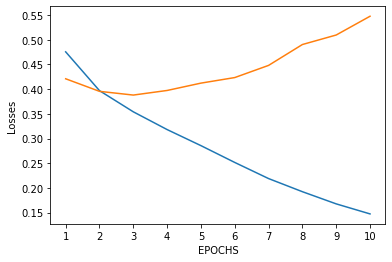

In [24]:
plt.plot(epoch_list,trainloss_list)
plt.plot(epoch_list,validloss_list)
plt.xticks(epoch_list)
plt.xlabel("EPOCHS")
plt.ylabel("Losses")
plt.show()